In [1]:
from open_ephys.analysis import Session
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import re

def AlignToTriggersAndFIndEphysTimestamps(Port_intimes,trial_id,first_poke_times,trial_start,TrialStart_EphysTime,FirstPoke_EphysTime):

    new_TS = []
    for index, trial in enumerate(trial_id):
        if np.isnan(Port_intimes[index]):
            new_TS = new_TS + [np.nan]
        else:

            current_poke_event_time = Port_intimes[index]

            # find ech relevant timestamps
            CurrentTrial_startTS = trial_start[trial-1]
            First_pokeTS = first_poke_times[trial-1]

            # last trial has no next trial start
            if trial == trial_id[-1]:
                NextTrial_startTS = 9999999999999
            else:
                NextTrial_startTS = np.unique(trial_start)[trial]

            trialstart_diff =  abs(CurrentTrial_startTS - current_poke_event_time)

            EphysTS = TrialStart_EphysTime[trial-1]
            current_dist = current_poke_event_time - CurrentTrial_startTS 
            distance = EphysTS + current_dist

            new_TS = new_TS + [distance]
            
    return(new_TS)


def align_open_ephys_processors(main_processor_tuple, aux_processor_tuples, session_path=None, synch_channel=1):

    session_data = Session(str(session_path))
    if len(session_data.recordnodes) != 1:
        raise ValueError("should be exactly one record node.")
    if len(session_data.recordnodes[0].recordings) != 1:
        raise ValueError("Should be exactly one recording.")
        
    for rn, recordnode in enumerate(session_data.recordnodes):
        for r, recording in enumerate(recordnode.recordings):
            # Synch
            recording.add_sync_line(
                synch_channel,
                main_processor_tuple[0],
                main_processor_tuple[1],
                main=True,
            )
            for aux_processor in aux_processor_tuples:
                recording.add_sync_line(
                    synch_channel,
                    aux_processor[0],
                    aux_processor[1],
                    main=False,
                )
            print('this should be zero:')
            print(rn)
        
    return recording



set paths:

In [2]:
## set paths!

mouse_implant_recording = '178_1_7'


OE_processor_path = r"/ceph/sjones/projects/sequence_squad/data/raw_neuropixel/OE_DATA/EJT178/300322/2022-03-30_13-48-39/Record Node 103/experiment1/recording1/continuous"
OE_raw_path = r"/ceph/sjones/projects/sequence_squad/data/raw_neuropixel/OE_DATA/EJT178/300322/2022-03-30_13-48-39/"

# this is the path to a histology file, this is needed in order to know the exact depth/location of each electrode
hist_path = r"/ceph/sjones/projects/sequence_squad/data/histology/Neuropixel_tracks/EJT178/brainreg/manual_segmentation/standard_space/tracks/"
hist_file = 'implant1'


##### check date at bottom lines up:
PATH = r"/ceph/sjones/projects/sequence_squad/organised_data/animals"

for file_ in os.listdir(PATH):
    if 'EJT' in file_.split('_')[0]:
        mouse_number = int(re.findall(r'\d+', file_.split('_')[0])[0])
        implant_number = int(re.findall(r'\d+', file_.split('_')[-1])[0])
        if mouse_implant_recording.split('_')[0] == str(mouse_number):
            if mouse_implant_recording.split('_')[1] == str(implant_number):
                mouse_name = file_.split('_')[0]
                implant_num = implant_number
                PATH = os.path.join(PATH,file_)
                break
for file_ in os.listdir(PATH):
    if 'recording' in file_.split('_')[0]:
        if mouse_implant_recording.split('_')[-1] == str(re.findall(r'\d+', file_.split('_')[0])[0]):
            date_file = file_
            org_data_path = os.path.join(PATH,date_file)
            break
            
print('---------------------------------------------------')
print('DATES should line up:')
print(org_data_path)
print(OE_raw_path)
print(OE_processor_path)
print('---------------------------------------------------')

---------------------------------------------------
DATES should line up:
/ceph/sjones/projects/sequence_squad/organised_data/animals/EJT178_implant1/recording7_30-03-2022
/ceph/sjones/projects/sequence_squad/data/raw_neuropixel/OE_DATA/EJT178/300322/2022-03-30_13-48-39/
/ceph/sjones/projects/sequence_squad/data/raw_neuropixel/OE_DATA/EJT178/300322/2022-03-30_13-48-39/Record Node 103/experiment1/recording1/continuous
---------------------------------------------------


set processor variables to use

In [3]:
#sample rate:
Fs = 2500

## import NP track position:
import pandas as pd

probe_track_file = hist_path + hist_file + '.csv'

implant_df = pd.read_csv(probe_track_file)

import re
count = 0
for processor in os.listdir(OE_processor_path):
    if count == 0:
        main1 = int(re.findall(r'\d+', processor)[0])
        main1_2 = processor.split('.')[-1]
    elif count == 1:
        main2 = int(re.findall(r'\d+', processor)[0])
        main2_2 = processor.split('.')[-1]
    elif count == 2:
        main3 = int(re.findall(r'\d+', processor)[0])
        main3_2 = processor.split('.')[-1]
    count +=1 

main_processor_tuple=(main1, main1_2)

aux_processor_tuples=((main2,main2_2),(main3,main3_2))


In [5]:
aux_processor_tuples

((109, '1'), (109, '0'))

load in OE data and align across processors (global alignment) 

In [6]:

### LOAD in data: this could take a few minutes
recording = align_open_ephys_processors(main_processor_tuple,aux_processor_tuples,OE_raw_path)
recording.compute_global_timestamps()


this should be zero:
0
Processor ID: 102, Stream Name: 0, Line: 1 (main sync line))
  First event sample number: 60920380
  Last event sample number: 512017786
  Total sync events: 15036
  Sample rate: 30000
Processor ID: 109, Stream Name: 1, Line: 1 (aux sync line))
  First event sample number: 5075153
  Last event sample number: 42662882
  Total sync events: 15036
  Scale factor: 12.001188100510143
  Actual sample rate: 2499.7525035646067
Processor ID: 109, Stream Name: 0, Line: 1 (aux sync line))
  First event sample number: 60901832
  Last event sample number: 511954579
  Total sync events: 15036
  Scale factor: 1.0000990105931002
  Actual sample rate: 29997.029976270802


In [7]:
dir(recording)

['Continuous',
 'Spikes',
 '__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_continuous',
 '_events',
 '_format',
 '_messages',
 '_spikes',
 '_version',
 'add_sync_line',
 'compute_global_timestamps',
 'continuous',
 'create_oebin_file',
 'detect_format',
 'detect_recordings',
 'directory',
 'events',
 'experiment_index',
 'format',
 'info',
 'load_continuous',
 'load_events',
 'load_messages',
 'load_spikes',
 'messages',
 'mmap_timestamps',
 'recording_index',
 'sort_events',
 'spikes',
 'sync_lines']

In [54]:
recording.continuous[0].global_timestamps

array([ 2030.03940331,  2030.03943665,  2030.03946999, ...,
       17067.79488633, 17067.79491967, 17067.79495301])

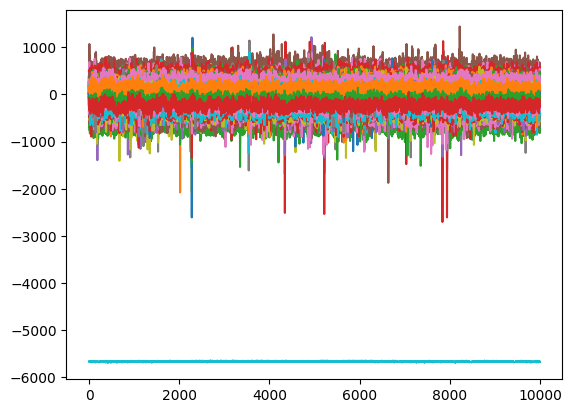

In [43]:
plt.plot(recording.continuous[0].samples[:10000])

align to depth information and to offset

In [27]:
data = recording.continuous[1].samples

if int(mouse_implant_recording.split('_')[0]) > 250:
    timestamps = recording.continuous[1].timestamps
else:
    timestamps = np.load(OE_processor_path + '/' + 'Neuropix-PXI-' + str(aux_processor_tuples[0][0]) + '.' + str(aux_processor_tuples[0][1]) + '/' + 'synchronized_timestamps.npy')

## chose 6 channels: #
channels = [50,100,150,200,250,300,350]

### add in region info based on depth:
try:
    callosum_middle_index = int(np.median(np.where(implant_df['Region acronym'].values == 'ccb')))
except:
    callosum_middle_index = int(np.median(np.where(implant_df['Region acronym'].values == 'ccg')))

proportion_in_motor_cortex = (callosum_middle_index/len(implant_df))
# there should be 400 channels per 4000um 
# tot_channels = 384
# bank_spacing = 20 # 20um
# channels_per_bank = 2
first_cortex_channel = int(proportion_in_motor_cortex * 400)

# save out data:
timestamps_s = timestamps/2500
timestamps_s_offset_adjusted = timestamps_s - timestamps_s[0]

channel_regions = []
for channel in channels:
    if channel > first_cortex_channel:
        channel_regions.append('m_crtex')
    elif channel < first_cortex_channel:
        channel_regions.append('striatum')

# save timestamp data
# save_file_path = org_data_path + r"/ephys/LFP/"
# if not os.path.isdir(save_file_path):
#     os.makedirs(save_file_path)
    
# np.save(save_file_path+ 'LFP_timestamps.npy',timestamps_s)
# np.save(save_file_path+ 'aligned_LFP_timestamps.npy',timestamps_s_offset_adjusted)

## free up memory
# del timestamps_s
# del timestamps_s_offset_adjusted


In [56]:
timestamps

array([ 2029.57876687,  2029.57916691,  2029.57956695, ...,
       17067.33413283, 17067.33453287, 17067.33493291])

loop over each chosen channel and save out data

In [11]:
### add in region info based on depth:
for chosen_channel in channels:
    data_channel = []
    chunk_size = 2000 # adjust this value to balance speed and memory usage
    for i in tqdm(range(0, len(data), chunk_size)):
        chunk = [data[j][chosen_channel] for j in range(i, min(i+chunk_size, len(data)))]
        data_channel += chunk
        
    if chosen_channel > first_cortex_channel:
        data_region = 'm-crtx'
    elif chosen_channel < first_cortex_channel:
        data_region = 'striatum'
        
    save_path = save_file_path + 'channel-' + str(chosen_channel) + '_REGION-' + data_region + "_LFP_data.npy"
    
    np.save(save_path,data_channel)
    print('data saved for channel ' + str(chosen_channel))
    # clean up for memory
    del data_channel
    
print('done')       

  0%|                                                                                                                                                                                                                                                                                           | 0/18796 [00:00<?, ?it/s]


data saved for channel 50


  0%|                                                                                                                                                                                                                                                                                           | 0/18796 [00:00<?, ?it/s]


data saved for channel 100


  0%|                                                                                                                                                                                                                                                                                           | 0/18796 [00:00<?, ?it/s]


data saved for channel 150


  0%|                                                                                                                                                                                                                                                                                           | 0/18796 [00:00<?, ?it/s]


data saved for channel 200


  0%|                                                                                                                                                                                                                                                                                           | 0/18796 [00:00<?, ?it/s]


data saved for channel 250


  0%|                                                                                                                                                                                                                                                                                           | 0/18796 [00:00<?, ?it/s]


data saved for channel 300


  0%|                                                                                                                                                                                                                                                                                           | 0/18796 [00:00<?, ?it/s]


data saved for channel 350
done
